# Lab 10: Factor Replication — Exploratory Analysis

<figure>
<a
href="https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/lab10_factor_replication.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

## Objective

This lab develops understanding of factor replication principles through
**exploratory exercises**. You’ll investigate concepts that underpin
rigorous factor analysis—HAC standard errors, alpha interpretation,
robustness thinking—without producing submission-ready outputs.

**Important**: This is not a template for Coursework 2. The scaffold
notebook ([open in
Colab](https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/coursework2_scaffold.ipynb))
provides that. This lab teaches you **how to think** about factor
replication so you can interpret scaffold outputs intelligently and
write critical analysis.

**Time estimate**: 60-90 minutes

## Learning Goals

By the end of this lab, you should be able to:

-   Explain why HAC standard errors matter in time-series regression
-   Interpret alpha tests and distinguish statistical vs. economic
    significance
-   Evaluate robustness by comparing results across subsamples
-   Identify limitations in factor research (selection bias, transaction
    costs)
-   Ask critical questions about factor replicability

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.float_format', '{:.4f}'.format)
np.random.seed(42)  # Reproducibility

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully

## Part 1: Understanding Autocorrelation and HAC Standard Errors

### Exercise 1.1: Visualising Autocorrelation

Financial returns often exhibit serial correlation. Let’s explore what
this means and why it matters for statistical inference.

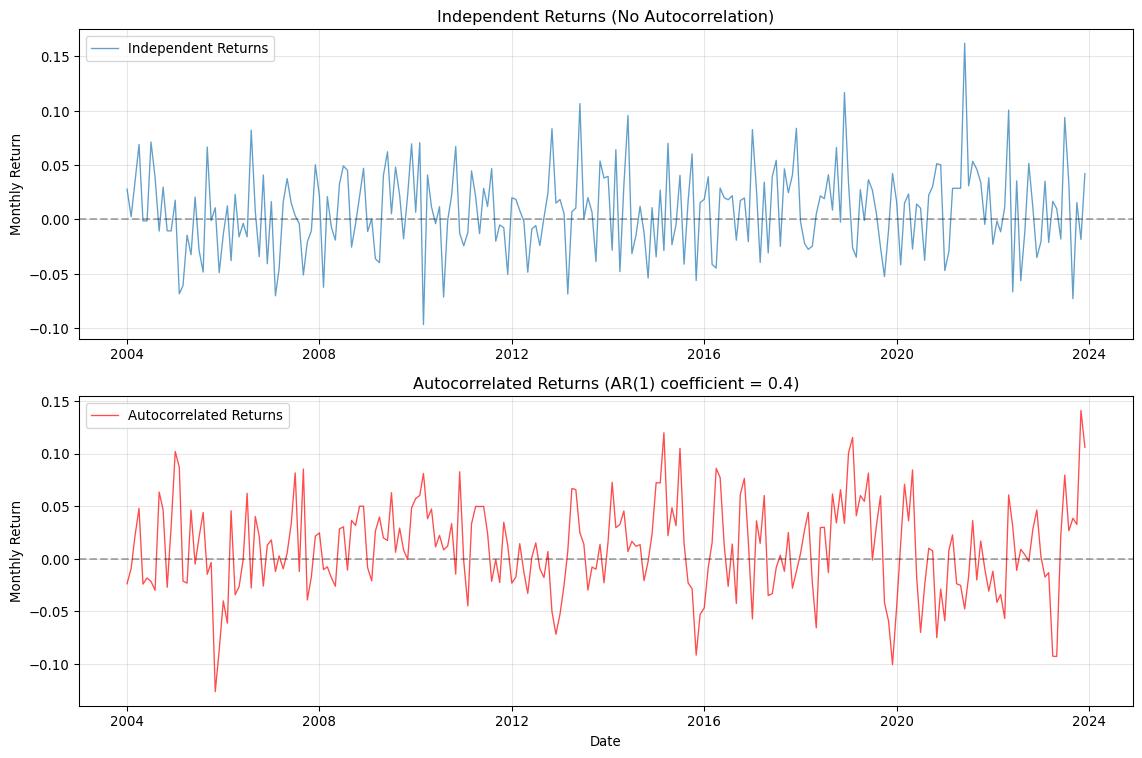

=== Autocorrelation at Lag 1 ===
Independent returns: -0.0465
Autocorrelated returns: 0.4151

In [2]:
# Generate two return series: one independent, one autocorrelated
n = 240  # 20 years monthly

# Series 1: Independent returns (no autocorrelation)
returns_iid = np.random.normal(0.008, 0.04, n)

# Series 2: Autocorrelated returns (AR(1) with coefficient 0.4)
returns_ar = np.zeros(n)
returns_ar[0] = np.random.normal(0.008, 0.04)
for i in range(1, n):
    returns_ar[i] = 0.008 + 0.4 * (returns_ar[i-1] - 0.008) + np.random.normal(0, 0.04)

# Convert to pandas Series with date index
dates = pd.date_range('2004-01-01', periods=n, freq='MS')
returns_iid = pd.Series(returns_iid, index=dates, name='IID Returns')
returns_ar = pd.Series(returns_ar, index=dates, name='AR(1) Returns')

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Time series plots
ax1.plot(returns_iid.index, returns_iid.values, label='Independent Returns', alpha=0.7, linewidth=1)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.set_ylabel('Monthly Return')
ax1.set_title('Independent Returns (No Autocorrelation)', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(returns_ar.index, returns_ar.values, label='Autocorrelated Returns', alpha=0.7, linewidth=1, color='red')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Return')
ax2.set_title('Autocorrelated Returns (AR(1) coefficient = 0.4)', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate autocorrelation
print("=== Autocorrelation at Lag 1 ===")
print(f"Independent returns: {returns_iid.autocorr(1):.4f}")
print(f"Autocorrelated returns: {returns_ar.autocorr(1):.4f}")

**Discussion questions:**

1.  What visual differences do you notice between the two series?
2.  How does autocorrelation affect the “smoothness” of the return
    series?
3.  If returns are autocorrelated, are observations truly independent?

### Exercise 1.2: Impact of Autocorrelation on Standard Errors

Now let’s see how autocorrelation affects statistical inference. We’ll
regress both series on a constant (testing if mean return is
significantly different from zero).

In [3]:
def test_mean_return(returns, name):
    """
    Test if mean return is significantly different from zero.
    Compare OLS vs HAC standard errors.
    """
    # Regression on constant only (testing mean)
    X = np.ones(len(returns))
    model = OLS(returns.values, X).fit()
    
    # HAC standard errors (Newey-West with 6 lags)
    cov_hac_matrix = cov_hac(model, nlags=6)
    se_hac = np.sqrt(cov_hac_matrix[0, 0])
    t_hac = model.params[0] / se_hac
    
    # Results
    results = pd.DataFrame({
        'Estimate': [model.params[0] * 100],  # Convert to %
        'OLS SE': [model.bse[0] * 100],
        'HAC SE': [se_hac * 100],
        'OLS t-stat': [model.tvalues[0]],
        'HAC t-stat': [t_hac],
        'SE Ratio (HAC/OLS)': [se_hac / model.bse[0]]
    }, index=[name])
    
    return results

# Test both series
results_iid = test_mean_return(returns_iid, 'Independent')
results_ar = test_mean_return(returns_ar, 'Autocorrelated')

print("=== Mean Return Tests: OLS vs HAC ===\n")
print(pd.concat([results_iid, results_ar]).round(4))

=== Mean Return Tests: OLS vs HAC ===

                Estimate  OLS SE  HAC SE  OLS t-stat  HAC t-stat  \
Independent       0.7904  0.2507  0.2358      3.1532      3.3524   
Autocorrelated    1.0104  0.2808  0.3964      3.5979      2.5488   

                SE Ratio (HAC/OLS)  
Independent                 0.9406  
Autocorrelated              1.4116  

**Discussion questions:**

1.  For independent returns, how do OLS and HAC standard errors compare?
    Why?
2.  For autocorrelated returns, is HAC standard error larger or smaller
    than OLS? Why?
3.  Does the conclusion about statistical significance change when using
    HAC vs OLS?
4.  What would happen if we used OLS for autocorrelated data without
    realising it?

**Key insight**: Autocorrelation violates OLS independence assumption,
causing standard errors to be understated. HAC corrects this by
adjusting for serial dependence. Using OLS on financial time-series data
leads to false positives (claiming significance when results are
actually noise).

## Part 2: Alpha Tests and Economic Interpretation

### Exercise 2.1: Simulating Factor Returns

Let’s create a simulated factor and test for alpha using CAPM
regression.

In [4]:
# Simulate market and factor returns
n = 240  # 20 years monthly

# Market returns
market = np.random.normal(0.008, 0.04, n)

# Factor returns with:
# - Positive alpha (0.003 = 0.3% monthly = 3.6% annualised)
# - Beta = 0.2 (some market exposure)
# - Autocorrelation (realistic for factors)
factor = np.zeros(n)
factor[0] = 0.003 + 0.2 * market[0] + np.random.normal(0, 0.03)
for i in range(1, n):
    factor[i] = 0.003 + 0.2 * market[i] + 0.3 * factor[i-1] + np.random.normal(0, 0.03)

# Convert to pandas
dates = pd.date_range('2004-01-01', periods=n, freq='MS')
market = pd.Series(market, index=dates, name='Market')
factor = pd.Series(factor, index=dates, name='Factor')

# Summary statistics
summary = pd.DataFrame({
    'Mean (% monthly)': [market.mean() * 100, factor.mean() * 100],
    'Std Dev (%)': [market.std() * 100, factor.std() * 100],
    'Sharpe Ratio': [(market.mean() / market.std()) * np.sqrt(12), 
                     (factor.mean() / factor.std()) * np.sqrt(12)]
}, index=['Market', 'Factor'])

print("=== Summary Statistics ===\n")
print(summary.round(3))

=== Summary Statistics ===

        Mean (% monthly)  Std Dev (%)  Sharpe Ratio
Market            0.5460       3.9980        0.4730
Factor            1.1070       3.0960        1.2390

**Discussion questions:**

1.  Which has higher mean return: market or factor?
2.  Which has higher volatility (risk)?
3.  Which has better risk-adjusted return (Sharpe ratio)?
4.  Can you tell from summary stats alone whether factor has significant
    alpha?

### Exercise 2.2: CAPM Alpha Regression

Now test for alpha by regressing factor on market.

In [5]:
# CAPM regression
X = sm.add_constant(market.values)
model = OLS(factor.values, X).fit()

# HAC standard errors
cov_hac_matrix = cov_hac(model, nlags=6)
se_hac = np.sqrt(np.diag(cov_hac_matrix))
t_hac = model.params / se_hac

# Results table
alpha_results = pd.DataFrame({
    'Coefficient': model.params,
    'OLS SE': model.bse,
    'HAC SE': se_hac,
    'HAC t-stat': t_hac,
    'OLS p-value': model.pvalues
}, index=['Alpha', 'Beta'])

# Add R-squared
alpha_results.loc['R-squared', 'Coefficient'] = model.rsquared

print("=== CAPM Alpha Test ===")
print(f"Regression: Factor = Alpha + Beta × Market + error\n")
print(alpha_results.round(4))

# Interpretation
alpha_monthly = model.params[0]
alpha_annual = alpha_monthly * 12
t_stat = t_hac[0]

print(f"\n📊 INTERPRETATION:")
print(f"   Alpha = {alpha_monthly*100:.3f}% monthly ({alpha_annual*100:.2f}% annualised)")
print(f"   Beta = {model.params[1]:.3f} (market exposure)")
print(f"   t-statistic = {t_stat:.2f}")

if abs(t_stat) > 1.96:
    print(f"   ✓ Alpha is statistically significant at 5% level (|t| > 1.96)")
    print(f"     Factor earns excess return beyond market exposure")
else:
    print(f"   ✗ Alpha is NOT statistically significant (|t| < 1.96)")
    print(f"     Cannot reject null hypothesis of zero alpha")

print(f"\n   R² = {model.rsquared:.3f} ({model.rsquared*100:.1f}% of factor variance explained by market)")

=== CAPM Alpha Test ===
Regression: Factor = Alpha + Beta × Market + error

           Coefficient  OLS SE  HAC SE  HAC t-stat  OLS p-value
Alpha           0.0099  0.0019  0.0025      3.9217       0.0000
Beta            0.2078  0.0483  0.0477      4.3519       0.0000
R-squared       0.0720     NaN     NaN         NaN          NaN

📊 INTERPRETATION:
   Alpha = 0.993% monthly (11.92% annualised)
   Beta = 0.208 (market exposure)
   t-statistic = 3.92
   ✓ Alpha is statistically significant at 5% level (|t| > 1.96)
     Factor earns excess return beyond market exposure

   R² = 0.072 (7.2% of factor variance explained by market)

**Discussion questions:**

1.  What is the estimated alpha? Is it positive or negative?
2.  Is alpha statistically significant (using HAC t-statistic)?
3.  What does beta tell you about factor’s market exposure?
4.  What does R² tell you about how much factor is driven by market?
5.  Even if alpha is statistically significant, is it economically
    meaningful? (Consider transaction costs of ~0.2-0.5% monthly for
    real portfolios)

**Key insight**: Alpha measures excess return not explained by market.
Positive and significant alpha suggests factor generates returns beyond
market exposure. But statistical significance doesn’t guarantee economic
exploitability—must consider transaction costs, implementation
constraints, and risk.

## Part 3: Robustness Thinking

### Exercise 3.1: Sample Split

A single significant result could be luck. Robustness checks test if
results hold under alternative specifications. Let’s start with sample
split.

In [6]:
# Split data at midpoint
midpoint = len(factor) // 2
dates_split = factor.index[midpoint]

# First half
market_1 = market.iloc[:midpoint]
factor_1 = factor.iloc[:midpoint]

# Second half
market_2 = market.iloc[midpoint:]
factor_2 = factor.iloc[midpoint:]

def run_alpha_test(factor_ret, market_ret, period_name):
    """Run CAPM alpha test with HAC standard errors."""
    X = sm.add_constant(market_ret.values)
    model = OLS(factor_ret.values, X).fit()
    
    # HAC standard errors
    cov_hac_matrix = cov_hac(model, nlags=6)
    se_hac = np.sqrt(np.diag(cov_hac_matrix))
    t_hac = model.params / se_hac
    
    results = {
        'Period': period_name,
        'Alpha (% monthly)': model.params[0] * 100,
        'HAC SE': se_hac[0] * 100,
        't-statistic': t_hac[0],
        'Significant?': 'Yes' if abs(t_hac[0]) > 1.96 else 'No',
        'Beta': model.params[1],
        'R²': model.rsquared,
        'Observations': len(factor_ret)
    }
    return results

# Run tests
results_1 = run_alpha_test(factor_1, market_1, 
                           f"{factor.index[0].year}-{factor.index[midpoint-1].year}")
results_2 = run_alpha_test(factor_2, market_2, 
                           f"{factor.index[midpoint].year}-{factor.index[-1].year}")

# Combine
robustness = pd.DataFrame([results_1, results_2]).set_index('Period')

print("=== Robustness Check: Sample Split ===\n")
print(robustness.round(3))

=== Robustness Check: Sample Split ===

           Alpha (% monthly)  HAC SE  t-statistic Significant?   Beta     R²  \
Period                                                                         
2004-2013             0.6220  0.3710       1.6790           No 0.2050 0.0610   
2014-2023             1.3730  0.3250       4.2310          Yes 0.1980 0.0770   

           Observations  
Period                   
2004-2013           120  
2014-2023           120  

**Discussion questions:**

1.  Is alpha significant in both periods?
2.  Is alpha magnitude similar across periods, or does it change?
3.  If alpha was significant in first period but not second, what might
    that suggest?
4.  If alpha is positive in one period but negative in another, is the
    factor robust?
5.  What conclusions would you draw about factor stability from this
    test?

**Key insight**: Robust factors show consistent performance across
subsamples. If results hold only in one period, the factor might be
sample-specific or driven by a unique market regime. Instability doesn’t
definitively prove factor is spurious, but it raises questions about
reliability and generalisability.

### Exercise 3.2: Rolling Window Analysis

Instead of just two periods, let’s look at how alpha evolves over time
using rolling windows.

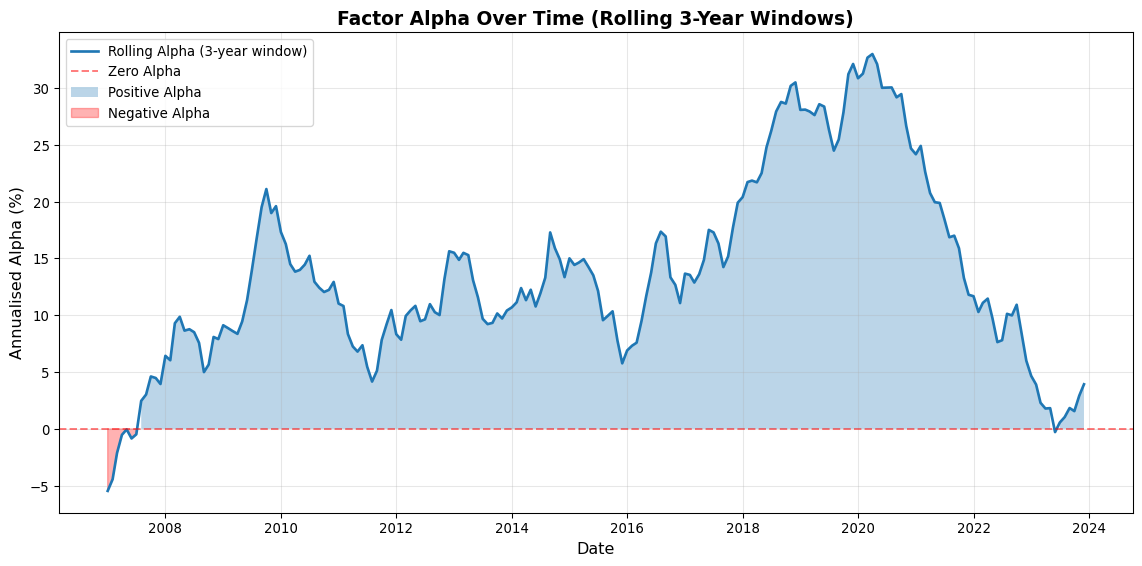

Rolling alpha statistics:
  Mean: 13.69%
  Std Dev: 8.35%
  Min: -5.45% (2007)
  Max: 32.99% (2020)
  % periods with positive alpha: 96.1%

In [7]:
# Calculate rolling alpha (3-year window)
window = 36  # months

rolling_alpha = []
rolling_dates = []

for i in range(window, len(factor)):
    factor_window = factor.iloc[i-window:i]
    market_window = market.iloc[i-window:i]
    
    # CAPM regression
    X = sm.add_constant(market_window.values)
    model = OLS(factor_window.values, X).fit()
    
    rolling_alpha.append(model.params[0] * 12 * 100)  # Annualised %
    rolling_dates.append(factor.index[i])

rolling_alpha = pd.Series(rolling_alpha, index=rolling_dates)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(rolling_alpha.index, rolling_alpha.values, linewidth=2, label='Rolling Alpha (3-year window)')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Alpha')
plt.fill_between(rolling_alpha.index, 0, rolling_alpha.values, 
                 where=(rolling_alpha >= 0), alpha=0.3, label='Positive Alpha')
plt.fill_between(rolling_alpha.index, 0, rolling_alpha.values, 
                 where=(rolling_alpha < 0), alpha=0.3, color='red', label='Negative Alpha')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annualised Alpha (%)', fontsize=12)
plt.title('Factor Alpha Over Time (Rolling 3-Year Windows)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Rolling alpha statistics:")
print(f"  Mean: {rolling_alpha.mean():.2f}%")
print(f"  Std Dev: {rolling_alpha.std():.2f}%")
print(f"  Min: {rolling_alpha.min():.2f}% ({rolling_alpha.idxmin().year})")
print(f"  Max: {rolling_alpha.max():.2f}% ({rolling_alpha.idxmax().year})")
print(f"  % periods with positive alpha: {(rolling_alpha > 0).mean()*100:.1f}%")

**Discussion questions:**

1.  How stable is alpha over time? Does it stay consistently
    positive/negative?
2.  Are there periods where alpha turns negative?
3.  What might explain variation in rolling alpha? (Market regimes?
    Structural changes? Arbitrage?)
4.  If you observed this pattern in real data, would you conclude the
    factor is reliably exploitable?

**Key insight**: Rolling analysis reveals time-variation in factor
performance. Factors can work in some periods and fail in others. Stable
alpha is more convincing than alpha that fluctuates wildly or reverses
sign. Instability might reflect changing market conditions, arbitrage
eroding profits, or sample-specific luck.

## Part 4: Critical Thinking About Factor Research

### Exercise 4.1: Transaction Cost Reality Check

Academic papers often report gross returns (before trading costs). But
real investors face costs. Let’s explore how costs affect
exploitability.

=== Transaction Cost Impact on Alpha ===

   Monthly Cost (%)  Annual Cost (%)  Gross Alpha (%)  Net Alpha (%)  \
0            0.0000           0.0000          11.9200        11.9200   
1            0.1000           1.2000          11.9200        10.7200   
2            0.2000           2.4000          11.9200         9.5200   
3            0.3000           3.6000          11.9200         8.3200   
4            0.4000           4.8000          11.9200         7.1200   
5            0.5000           6.0000          11.9200         5.9200   

  Exploitable?  
0          Yes  
1          Yes  
2          Yes  
3          Yes  
4          Yes  
5          Yes  

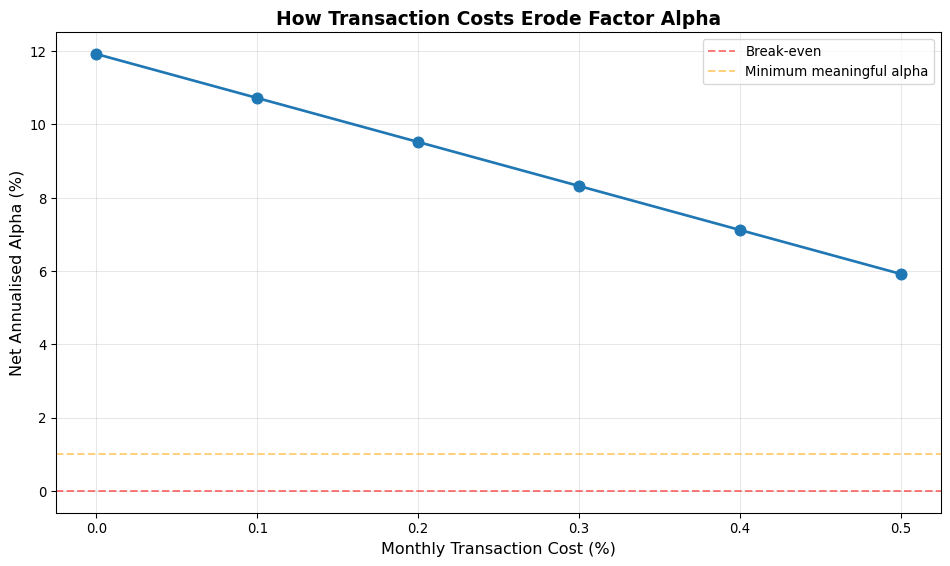

In [8]:
# Assume our factor requires monthly rebalancing
# Transaction costs depend on liquidity, portfolio size, and execution strategy
# Realistic range: 0.1% - 0.5% per month (includes bid-ask spreads, commissions, market impact)

cost_scenarios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Recompute CAPM alpha here to avoid relying on earlier cells
X_tc = sm.add_constant(market.values)
model_tc = OLS(factor.values, X_tc).fit()
alpha_tc = model_tc.params[0]

# Calculate net alpha under different cost assumptions
results_costs = []
for cost in cost_scenarios:
    gross_alpha = alpha_tc * 12 * 100  # Annualised %
    net_alpha = gross_alpha - (cost * 12)  # Subtract annual cost
    
    results_costs.append({
        'Monthly Cost (%)': cost,
        'Annual Cost (%)': cost * 12,
        'Gross Alpha (%)': gross_alpha,
        'Net Alpha (%)': net_alpha,
        'Exploitable?': 'Yes' if net_alpha > 1.0 else 'Marginal' if net_alpha > 0 else 'No'
    })

costs_df = pd.DataFrame(results_costs)
print("=== Transaction Cost Impact on Alpha ===\n")
print(costs_df.round(2))

# Visualise
plt.figure(figsize=(10, 6))
plt.plot(costs_df['Monthly Cost (%)'], costs_df['Net Alpha (%)'], 
         marker='o', linewidth=2, markersize=8)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')
plt.axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='Minimum meaningful alpha')
plt.xlabel('Monthly Transaction Cost (%)', fontsize=12)
plt.ylabel('Net Annualised Alpha (%)', fontsize=12)
plt.title('How Transaction Costs Erode Factor Alpha', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion questions:**

1.  At what transaction cost level does net alpha turn negative?
2.  Even if net alpha is positive, is it large enough to justify
    implementation?
3.  How do transaction costs affect the “break-even” account size for
    implementing a factor?
4.  Why might high-turnover factors (like momentum) be harder to exploit
    than low-turnover factors (like value)?
5.  If you read a paper reporting 8% gross alpha, what questions would
    you ask about exploitability?

**Key insight**: Gross alpha overstates exploitability. Always consider
transaction costs, especially for high-turnover strategies. Even
statistically significant alpha can be economically meaningless after
costs. This is a major reason many published factors fail in real-world
implementation.

### Exercise 4.2: Selection Bias Simulation

Let’s simulate the multiple testing problem that creates false
discoveries in factor research.

=== Selection Bias Simulation ===
Number of 'factors' tested: 100
True alpha for all factors: 0% (pure noise)
Significance level: 5.0%

RESULTS:
  Number appearing 'significant': 6
  Expected false positives: 5.0
  All significant findings are FALSE POSITIVES (Type I errors)

'Published' Factors:
   Factor  Alpha (% monthly)  t-statistic  p-value
0      45            -0.7250      -2.9550   0.0030
1      52             0.6130       2.4090   0.0170
2      59            -0.5240      -2.1570   0.0320
3      78            -0.4720      -2.0210   0.0440
4      82             0.7050       2.6620   0.0080
5      97            -0.9020      -3.6760   0.0000

IMPLICATION:
  If only 'significant' factors get published, the literature
  overrepresents spurious findings by construction.
  This is the source of the replication crisis.

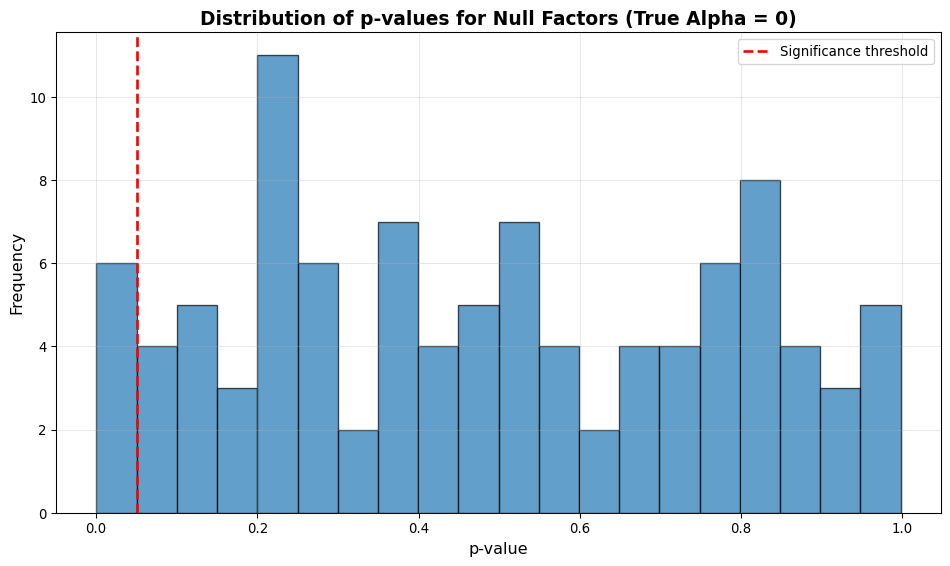

In [9]:
# Simulate many researchers each testing a potential "factor"
# None of these factors have true alpha (all are pure noise)
# But some will appear significant just by luck (5% false positive rate)

num_researchers = 100
num_obs = 240
significance_level = 0.05

# Storage for results
p_values = []
significant_factors = []

for i in range(num_researchers):
    # Generate random "factor" and market with zero true alpha (mean 0)
    random_factor = np.random.normal(0.0, 0.04, num_obs)
    market_sim = np.random.normal(0.0, 0.04, num_obs)
    
    # Test for alpha
    X = sm.add_constant(market_sim)
    model = OLS(random_factor, X).fit()
    
    p_values.append(model.pvalues[0])
    
    # "Publish" if significant
    if model.pvalues[0] < significance_level:
        significant_factors.append({
            'Factor': i+1,
            'Alpha (% monthly)': model.params[0] * 100,
            't-statistic': model.tvalues[0],
            'p-value': model.pvalues[0]
        })

# How many false positives?
num_significant = len(significant_factors)
expected_false = num_researchers * significance_level

print(f"=== Selection Bias Simulation ===")
print(f"Number of 'factors' tested: {num_researchers}")
print(f"True alpha for all factors: 0% (pure noise)")
print(f"Significance level: {significance_level*100}%")
print(f"\nRESULTS:")
print(f"  Number appearing 'significant': {num_significant}")
print(f"  Expected false positives: {expected_false:.1f}")
print(f"  All significant findings are FALSE POSITIVES (Type I errors)")

if significant_factors:
    print(f"\n'Published' Factors:")
    print(pd.DataFrame(significant_factors).round(3))

print(f"\nIMPLICATION:")
print(f"  If only 'significant' factors get published, the literature")
print(f"  overrepresents spurious findings by construction.")
print(f"  This is the source of the replication crisis.")

# Distribution of p-values
plt.figure(figsize=(10, 6))
plt.hist(p_values, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Significance threshold')
plt.xlabel('p-value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of p-values for Null Factors (True Alpha = 0)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion questions:**

1.  How many “significant” results appeared even though true alpha is
    zero?
2.  Is this close to the expected 5% false positive rate?
3.  If journals only publish significant results, what fraction of
    published factors are false positives?
4.  How does this simulation relate to the ~300 published equity factors
    in real finance literature?
5.  What practices could reduce false discovery rate? (Pre-registration?
    Higher significance thresholds? Out-of-sample testing?)

**Key insight**: Multiple testing creates false discoveries even under
rigorous statistical practices. With hundreds of factors tested, many
spurious findings get published whilst null results remain in file
drawers. This selection bias inflates published returns and explains why
many factors fail replication. Jensen et al. (2024) document this
systematically.

## Part 5: Connecting to Coursework 2

### What You’ve Learned vs. What You’ll Apply

**Today’s lab explored concepts:**

-   HAC standard errors correct for autocorrelation (prevents false
    positives)
-   Alpha tests isolate excess returns beyond market exposure
-   Robustness checks (sample split, rolling windows) test stability
-   Transaction costs reduce net alpha (affects exploitability)
-   Selection bias creates false discoveries (replication crisis)

**For Coursework 2, you’ll:**

1.  Use scaffold notebook to run these analyses on real JKP factor data
2.  Interpret outputs using understanding developed today
3.  Write critical analysis discussing significance, robustness,
    limitations
4.  Engage with Jensen et al. (2024) on selection bias and replication
5.  Provide investment recommendations considering costs and risks

### Critical Analysis Questions to Ask

When interpreting your Coursework 2 results, ask:

**Statistical questions:**

-   Is alpha statistically significant using HAC standard errors?
-   How does significance change if you use higher threshold (t \> 3)?
-   Are results robust to sample split? If not, why?

**Economic questions:**

-   What is alpha magnitude after transaction costs?
-   Is net alpha large enough to justify implementation?
-   How does your result compare to original published paper?

**Methodological questions:**

-   Could selection bias explain why original paper found stronger
    results?
-   Has factor performance declined post-publication (arbitrage
    erosion)?
-   What limitations affect your replication (data, sample period,
    methodology)?

**Investment questions:**

-   Would you recommend implementing this factor in a real portfolio?
-   What risks and constraints would practitioners face?
-   What further robustness tests would you want before making
    investment decision?

### Next Steps

1.  **Read Jensen et al. (2024)**: “Is There a Replication Crisis in
    Finance?” — Essential for understanding replication methodology and
    selection bias
2.  **Run scaffold notebook**: See what actual outputs look like with
    real JKP data
3.  **Choose factor**: Value (HML) or Momentum (MOM) are
    well-documented; Quality (RMW) or Size (SMB) also work
4.  **Draft interpretation**: Practice writing paragraphs interpreting
    alpha, robustness, limitations
5.  **Office hours**: Ask conceptual questions about interpretation (not
    code debugging)

## Summary

Today’s lab developed principles for factor replication:

-   **HAC standard errors** are essential for honest inference in
    time-series data
-   **Alpha tests** reveal excess returns, but significance ≠
    exploitability
-   **Robustness checks** separate real patterns from sample-specific
    noise
-   **Transaction costs** can eliminate seemingly significant alpha
-   **Selection bias** inflates published results, explaining
    replication failures

**These principles enable critical analysis**—the 35% component of
Coursework 2. Scaffold provides outputs; understanding provides
interpretation. Focus your effort on thinking deeply about what results
mean, not on perfecting code.

**Week 11 preview**: Market prediction using factors. Same
principle-focused approach—understanding concepts, not copying
templates.